In [92]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import Project_library as pl
import jax
import jax.numpy as jnp

from scipy.special import kl_div 

In [52]:

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = [
    'CMU Serif Roman',  # primary CMU serif face
    'Times New Roman',  # fallback
    'Georgia',
    'serif'
]
plt.rcParams['axes.grid'] = True
# 3. Set the global font size:
plt.rcParams['font.size'] = 14  # change this number to taste

# 4. (Optional) Adjust axes titles and labels separately if you like:
plt.rcParams['axes.titlesize'] = 14 
plt.rcParams['axes.labelsize'] = 14

### Illustrate the changes in demand


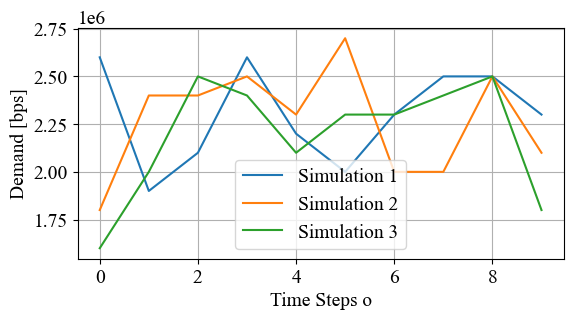

In [53]:
plt.figure(figsize=(6.27, 3))
for x in range(1, 4):
    number_of_users = 30
    s = []

    key = jax.random.PRNGKey(x)

    for i in range(number_of_users):
        s.append(jax.random.choice(key, jax.numpy.asarray([0, 1]), shape=(1,), p=jax.numpy.asarray([0.3, 0.7])))
        subkey, key = jax.random.split(key)

    key = jax.random.split(key, (number_of_users,))

    s = jax.numpy.array(s)

    alpha = 0.7
    beta = 0.2

    A = jax.numpy.asarray([[1-alpha, alpha], [beta, 1-beta]])

    O = 10

    time_series = jax.numpy.zeros((number_of_users, O))

    s = s.reshape((number_of_users))

    demands = pl.users_state_change(A, s, time_series, key)

    demand_over_time = jax.numpy.sum(demands, axis=0)*100000
    plt.plot(demand_over_time, label=f"Simulation {x}")

plt.legend()
plt.xlabel("Time Steps o")
plt.ylabel("Demand [bps]")
plt.savefig("demand_over_time.pdf",  bbox_inches='tight')
plt.show()

### Illustrate different value emperically

[0 0 0 0 0 0 0 0]
[1.000e+00 7.000e+00 7.500e+01 4.760e+02 1.307e+03 2.569e+03 3.015e+03
 1.990e+03 5.600e+02]
[0 0 0 0 1 1 1 1]
[0.000e+00 3.000e+00 4.000e+01 2.180e+02 8.670e+02 2.113e+03 3.146e+03
 2.641e+03 9.720e+02]
[1 1 1 1 1 1 1 1]
[   0.    0.   15.   87.  431. 1416. 2979. 3411. 1661.]
[[1.000e+00 7.000e+00 7.500e+01 4.760e+02 1.307e+03 2.569e+03 3.015e+03
  1.990e+03 5.600e+02]
 [0.000e+00 3.000e+00 4.000e+01 2.180e+02 8.670e+02 2.113e+03 3.146e+03
  2.641e+03 9.720e+02]
 [0.000e+00 0.000e+00 1.500e+01 8.700e+01 4.310e+02 1.416e+03 2.979e+03
  3.411e+03 1.661e+03]]


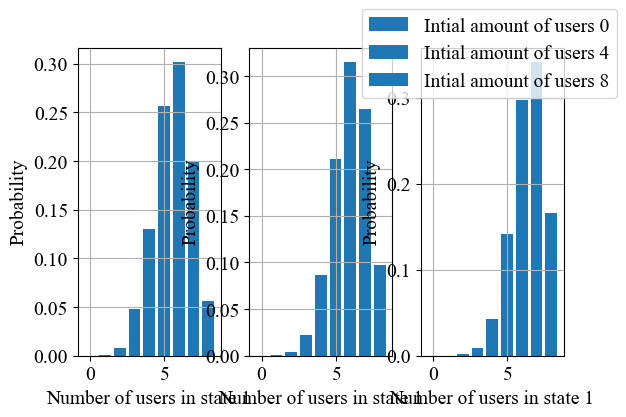

In [54]:
fig, axs = plt.subplots(1,3 , figsize=(6.27, 4), sharex=True)

number_of_realizations = 10000

key = jax.random.PRNGKey(0)

users_states = jnp.array([[0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0],[1,1,0,0,0,0,0,0],[1,1,1,0,0,0,0,0],[0,0,0,0,1,1,1,1],[1,1,1,1,1,0,0,0], [1,1,1,1,1,1,0,0],[1,1,1,1,1,1,1,0],  [1,1,1,1,1,1,1,1]]) 

users_states = users_states[jnp.asarray([0,4,8])]

intial_sum = jnp.sum(users_states)

time_series = jnp.zeros((users_states.shape[1],2))

outcome = jnp.zeros((users_states.shape[0],users_states.shape[1]+1))

# Now I want to run the simulation for a number of realizations with the same initial state
for k in range(outcome.shape[0]):
    print(users_states[k])
    for i in range(number_of_realizations):
        key = jax.random.split(key, (users_states.shape[1],))
        time_series = pl.users_state_change(A, users_states[k], time_series, key)
        # Okay now i sum up the time series for each time step 
        outcome = outcome.at[k,jnp.sum(time_series, axis=0)[1]].add(1)
        key = key[0]
    print(outcome[k])



print(outcome)
# Make a bar plot of the outcome normalized by the number of realizations
for i in range(outcome.shape[0]):
    axs[i].bar(jnp.arange(outcome.shape[1]), outcome[i]/number_of_realizations, label=f'Intial amount of users {jnp.sum(users_states[i])}')
    axs[i].set_xlabel('Number of users in state 1')
    axs[i].set_ylabel('Probability')
fig.legend()
#plt.title(f'Probability of users in state 1 after 1 time step given varying initial statse')
plt.savefig("probability_of_users_in_different_states_after_one_step.pdf",  bbox_inches='tight')
plt.show()

#### Calculate the same value using binomial convolution

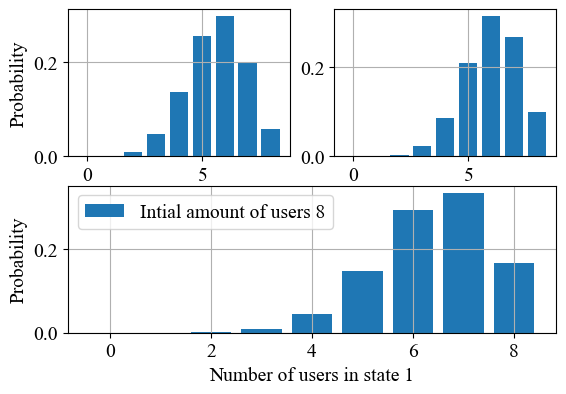

In [55]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(6.3, 4.2))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])  # 2 rows, 2 columns

# First row: 2 plots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Second row: 1 plot spanning both columns
ax3 = fig.add_subplot(gs[1, 0:2])  # All columns in second row

# List of axes for easy iteration
axs = [ax1, ax2, ax3]

active_users_in_state_one = jnp.sum(users_states, axis=1)
key = jax.random.PRNGKey(0)

M = users_states.shape[1]


for idx, act_users in enumerate(active_users_in_state_one):
    # Number of users in each state
    M1 = act_users
    M2 = M - M1

    k1 = jnp.arange(M1+1)
    k2 = jnp.arange(M2+1)


    # Binomial Distribution of each case
    Binom_from_on_to_on = jax.scipy.stats.binom.pmf(k1, n=M1,p=1-beta)
    Binom_from_off_to_on = jax.scipy.stats.binom.pmf(k2, n=M2, p=alpha)
    

    # Convolve the two distributions
    convolved = jax.scipy.signal.convolve(Binom_from_on_to_on, Binom_from_off_to_on, mode='full')


    # Normalize the convolved distribution
    convolved = convolved / jnp.sum(convolved)


    # Plot the convolved distribution bar plot
    axs[idx].bar(jnp.arange(convolved.shape[0]), convolved, label=f'Intial amount of users {act_users}')
    if idx == 0 or idx == 2:
        axs[idx].set_ylabel('Probability')
    axs[idx].set_xlabel('Number of users in state 1')

plt.legend()
plt.savefig("probability_of_initial_users_in_different_states_after_one_step_convolved.pdf",  bbox_inches='tight')

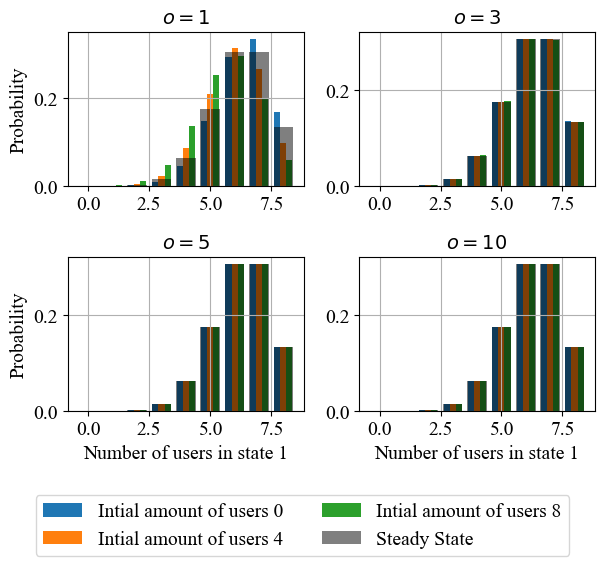

In [106]:
fig,axs = plt.subplots(2,2, figsize=(6.27, 5.5))
axs = axs.flatten()
key = jax.random.PRNGKey(0)


M = users_states.shape[1]

O = [1,3,5,10]

probabilities_after_steps = [jnp.linalg.matrix_power(A, o) for o in O]

width = 0.25
k_values = jnp.arange(M+1)

bing = [-1,0,1]
labels = []
for ido, o in enumerate(O):
    for idk, act_users in enumerate(active_users_in_state_one):
        # Number of users in each state
        M1 = act_users
        M2 = M - M1

        k1 = jnp.arange(M1+1)
        k2 = jnp.arange(M2+1)


        # Binomial Distribution of each case
        Binom_from_on_to_on = jax.scipy.stats.binom.pmf(k1, n=M1,p=probabilities_after_steps[ido][0, 1])
        Binom_from_off_to_on = jax.scipy.stats.binom.pmf(k2, n=M2, p=probabilities_after_steps[ido][1, 1])
        
        steady_state_on = alpha / (alpha + beta)
        k3 = jnp.arange(M+1)


        # Binomial Distribution of steady state
        Binom_from_on_to_on_steady = jax.scipy.stats.binom.pmf(k3, n=M, p=steady_state_on)

        # Convolve the two distributions
        convolved = jax.scipy.signal.convolve(Binom_from_on_to_on, Binom_from_off_to_on, mode='full')


        # Normalize the convolved distribution
        convolved = convolved / jnp.sum(convolved)

        # Plot the convolved distribution bar plot
        axs[ido].bar(k_values+bing[idk]*width, convolved,width=width, alpha=1)

        if ido == 0:
            labels.append(f'Intial amount of users {act_users}')

        axs[ido].set_title(f'$o = {o}$')

        if ido == 0 or ido == 2:
            axs[ido].set_ylabel('Probability')
        if ido > 1:
            axs[ido].set_xlabel('Number of users in state 1')
    axs[ido].bar(k_values, Binom_from_on_to_on_steady, width=0.8, alpha=0.5, label='Steady State', color='black')
labels.append('Steady State')
fig.legend(labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust rect to create space at the bottom
plt.savefig("convergence_toward_steady_state_with_different_initial_points.pdf",  bbox_inches='tight')

[1 1 1 1 0 0 0 0]
1 [0.000e+00 2.000e+00 3.100e+01 2.020e+02 8.340e+02 2.080e+03 3.179e+03
 2.705e+03 9.670e+02]
3 [0.000e+00 2.000e+00 1.800e+01 1.280e+02 5.940e+02 1.678e+03 3.075e+03
 3.124e+03 1.381e+03]
5 [0.000e+00 1.000e+00 2.200e+01 1.450e+02 6.150e+02 1.798e+03 3.040e+03
 3.042e+03 1.337e+03]
10 [0.000e+00 1.000e+00 1.900e+01 1.600e+02 5.880e+02 1.747e+03 3.097e+03
 3.077e+03 1.311e+03]
KL Divergence for 1 time steps: 0.0003
KL Divergence for 3 time steps: 0.0005
KL Divergence for 5 time steps: 0.0001
KL Divergence for 10 time steps: 0.0003


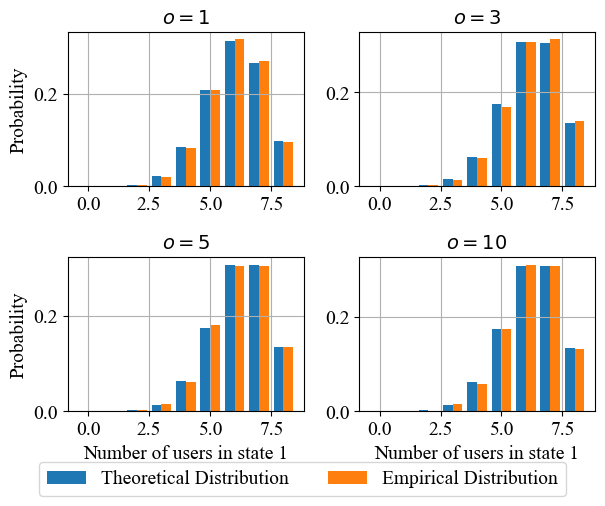

In [ ]:
# Evaluate the empirical distribution vs. the theoretical distribution, just with 4 active user case and 8 in total
fig, axs = plt.subplots(2, 2, figsize=(6.27, 5.5))
axs = axs.flatten()


key = jax.random.PRNGKey(0)

act_users = 4
M = 8

number_of_realizations = 10000

o = [1, 3, 5, 10]

width = 0.4

users_states = jnp.array([[1, 1, 1, 1, 0, 0, 0, 0]])

time_series = jnp.zeros((users_states.shape[1],o[3]))

pmfs = []

for ido, o in enumerate(O):
    # Number of users in each state
    M1 = act_users
    M2 = M - M1

    k1 = jnp.arange(M1+1)
    k2 = jnp.arange(M2+1)


    # Binomial Distribution of each case
    Binom_from_on_to_on = jax.scipy.stats.binom.pmf(k1, n=M1,p=probabilities_after_steps[ido][0, 1])
    Binom_from_off_to_on = jax.scipy.stats.binom.pmf(k2, n=M2, p=probabilities_after_steps[ido][1, 1])
    
    steady_state_on = alpha / (alpha + beta)
    k3 = jnp.arange(M+1)


    # Binomial Distribution of steady state
    Binom_from_on_to_on_steady = jax.scipy.stats.binom.pmf(k3, n=M, p=steady_state_on)

    # Convolve the two distributions
    convolved = jax.scipy.signal.convolve(Binom_from_on_to_on, Binom_from_off_to_on, mode='full')


    # Normalize the convolved distribution
    convolved = convolved / jnp.sum(convolved)

    # Plot the convolved distribution bar plot
    axs[ido].bar(k_values+(-width/2), convolved,width=width, alpha=1)

    # Save the PMF for later comparison
    pmfs.append(convolved)

# Calculate the empirical distribution
outcome = jnp.zeros((O[3],users_states.shape[1]+1))

print(users_states[k])
for i in range(number_of_realizations):
    key = jax.random.split(key, (users_states.shape[1],))
    time_series = pl.users_state_change(A, users_states[k], time_series, key)
    # Okay now i sum up the time series for each time step 
    sum_of_time = jnp.sum(time_series, axis=0)

    for j in range(sum_of_time.shape[0]):
        outcome = outcome.at[j, sum_of_time[j]].add(1) 
    key = key[0]

for ido, o in enumerate(O):
    print(o, outcome[o])
    axs[ido].bar(k_values+(width/2), outcome[o]/number_of_realizations, width=width, alpha=1)

    axs[ido].set_title(f'$o = {o}$')

    if ido == 0 or ido == 2:
        axs[ido].set_ylabel('Probability')
    if ido > 1:
        axs[ido].set_xlabel('Number of users in state 1')


fig.legend(["Theoretical Distribution", "Empirical Distribution"], loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.01))
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust rect to create space at the bottom

plt.savefig("empirical_vs_theoretical_distribution.pdf",  bbox_inches='tight')

# Calculate the KL-divergene between the empirical and theoretical distribution
for ido, o in enumerate(O):
    empirical_distribution = outcome[o] / number_of_realizations
    theoretical_distribution = pmfs[ido]

    kl_divergence = kl_div(empirical_distribution, theoretical_distribution).sum()
    
    print(f"KL Divergence for {o} time steps: {kl_divergence:.4f}")
